# Attribution analysis walkthrough
**Authorship:**
Adam Klie (last updated: *07/16/2023*)
***
**Description:**
This notebook is meant to serve as a guide for performing attribution analysis on a trained model. The notebook will walk through the steps of performing the analysis and interpreting the results.
***

# Background
Attribution analysis is a general interpretability method for machine learning, that aims to decompose a model's predictions into the contribution of each feature. In genomics, the first attribution analyses were performed my doing *in silico* saturation mutagenesis in which each nucleotide in a given input sequence was mutated to every other nucleotide, and the effect of the mutation on the model's prediction was measured. More recently, attribution analysis have been performed using gradient-based methods, which are less computationally expensive and can scale to larger sequences. Attribution analysis are often used to validate that a model is learning bioligically meaningful features, and unlike filter interpretation methods discussed in detail here, can do so for individual sequences.

Credit: Some of the text and ideas presented here are adapted form the wonderful slide deck by [Avanti Shrikumar](https://docs.google.com/presentation/d/1JCLMTW7ppA3Oaz9YA2ldDgx8ItW9XHASXM1B3regxPw/edit#slide=id.p)

# Running an attribution analysis
Let's run an attribution analysis using the DeepSTARR model trained in (EvoAug publication)[https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-02941-w] (original architecture design in de Almeida et al 2022). We downloaded the model from here: https://zenodo.org/record/7767325 using the following command:

In [ ]:
#!wget https://zenodo.org/record/7767325/files/attr_analysis.zip
#!unzip attr_analysis.zip

## Load in a model
To use the EvoAug model, we need to load in the model architecture and weights. We will need to use the original EvoAug code to do this, as the weights were saved in a custom LightningModule checkpoint.

In [1]:
# General purpose imports
import os
import torch
import numpy as np

In [2]:
# Uncomment to install evoaug and evoaug_analysis to your environment
#!pip install evoaug
#!pip install git+https://github.com/p-koo/evoaug_analysis.git

In [3]:
# Load the DeepSTARR model that was trained in the evo_aug paper
from evoaug import evoaug
from evoaug_analysis import utils, model_zoo
ckpt_path = "/cellar/users/aklie/projects/ML4GLand/models/DeepSTARR/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt"  # TODO: change this path to the path of the checkpoint file on your machine
deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(
    deepstarr, 
    criterion=loss, 
    optimizer=optimizer_dict, 
    augment_list=[]
)
# load model weights
model = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path).eval()

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file projects/ML4GLand/models/DeepSTARR/evoaug/attr_analysis/DeepSTARR_baseline_1.ckpt`


We also provide a EUGENe trained model in the commented out section below if you are unable to get the above code working.

In [4]:
# TODO: train model
#from eugene import models
#arch = models.DeepSTARR(input_len=249, output_dim=2)
#models.SequenceModule.load_from_checkpoint(ckpt_path, arch=arch)

## Load in the data
We will use the same processed data as in the EvoAug paper that can be downloaded from here https://zenodo.org/record/7265991 witg the following command:

In [ ]:
!wget https://zenodo.org/record/7265991/files/DeepSTARR_data.h5

In [5]:
# h5py lets us load the data from the h5 file
import h5py

In [6]:
# Load in test data from the evo_aug paper, most likely will not need other than for testing
dataset = h5py.File("/cellar/users/aklie/data/ml4gland/pubs/deAlmeida22/evo_aug/DeepSTARR_data.h5", 'r')  # TODO: change this path to the path of the h5 file on your machine
x_test = np.array(dataset['X_test']).astype(np.float32)
y_test = np.array(dataset['Y_test']).astype(np.float32)
x_test.shape, y_test.shape

((41186, 4, 249), (41186, 2))

In [7]:
# Just grab a random batch of 100 sequences for testing
x_ind = np.random.choice(x_test.shape[0], 100, replace=False)
batch = x_test[x_ind]

## Choosing a reference (or baseline)
Many attribution methods require a reference set of inputs. Often, the goal is to choose a reference that has no predictive features (will depend on your model) but remains in the distribution of the test data. The reference gets a "baseline" score from the model that can be used by different attribution methods to determine the contribution of each feature to the model's prediction. Below we use SeqExplainer to generate a set of reference sequences that are just all zero matrices.

In [9]:
# Master function for getting reference sequences in SeqExplainer
from seqexplainer.attributions import get_reference

In [10]:
# Get a batch of reference sequences with all zeros
zero_ref = get_reference(batch, "zero")

You can even pass in your own functions to generate a reference. We provide a toy wxample below that just modifies the first base of the sequence to an all zeros vector.

In [11]:
def ablate_first_base(seqs):
    """
    Change the first base of each sequence in `seqs` to A, C, G, or T.
    """
    seqs[:, :, 0] = [0, 0, 0, 0]
    return seqs

In [12]:
ablated_ref = get_reference(batch, ablate_first_base)

Sometimes, model can give very unpredictable behavior on out-of-distribution inputs (like the all-zeros input or an “averaged gc content” input). It's always good to check that your reference gives reasonable predictions.

In [ ]:
# Example of all 0s reference
model(torch.tensor(zero_ref, dtype=torch.float32))

We have noted that models can predict variable or really high values for these types of references. If you find your attributions have a “positive haze” or a “negative haze” (i.e. lots of bases one after the other with a slight positive importance/negative importance), this could be due to a poor choice of reference.

More commonly used references in practice are mononucleotide or dinucleotide shuffled versons of the test input sequences.

In [13]:
# We will use probably the most common reference sequence, the dinucleotide shuffled sequence
ref = get_reference(batch, "dinuc_shuffle")

In [14]:
# Example of all 0s reference
model(torch.tensor(ref, dtype=torch.float32))

tensor([[ 0.8106, -2.7295],
        [ 0.7735, -2.7493],
        [ 0.7475, -2.7695],
        [ 0.7577, -2.7519],
        [ 0.7838, -2.7496],
        [ 0.7650, -2.7470],
        [ 0.7735, -2.7365],
        [ 0.7632, -2.7500],
        [ 0.7342, -2.7633],
        [ 0.7485, -2.7774],
        [ 0.7416, -2.7490],
        [ 0.7739, -2.7524],
        [ 0.7650, -2.7470],
        [ 0.7506, -2.7591],
        [ 0.7577, -2.7457],
        [ 0.7424, -2.7685],
        [ 0.7650, -2.7505],
        [ 0.7392, -2.7647],
        [ 0.7985, -2.7442],
        [ 0.7353, -2.7614],
        [ 0.7865, -2.7359],
        [ 0.7832, -2.7320],
        [ 0.7521, -2.7517],
        [ 0.7538, -2.7444],
        [ 0.7431, -2.7503],
        [ 0.7364, -2.7571],
        [ 0.7552, -2.7491],
        [ 0.7576, -2.7511],
        [ 0.7519, -2.7554],
        [ 0.7500, -2.7522],
        [ 0.7145, -2.7644],
        [ 0.7515, -2.7584],
        [ 0.7255, -2.7716],
        [ 0.7751, -2.7402],
        [ 0.7857, -2.7457],
        [ 0.7804, -2

SeqExplainer also offers gc content matched, random, and profile matched references. We encourage you to try different ones out and see how they affect your attribution scores!

## Running different attribution methods
Now let's actually calculate some attributions. EUGENe currently offers ISM (naive version), InputXGradient, DeepLift, DeepLiftShap, and GradientShap for attribution analysis. We demonstrate how to run each of these below.

In [15]:
# Load in the attribute function from seqexplainer
from seqexplainer import attribute

In [16]:
# Let's start with a naive ISM that mutates every nucleotide to every other nucleotids and measures the effect on the model's prediction
ism_attrs = attribute(
    model,
    inputs=torch.tensor(batch, dtype=torch.float32),
    method="NaiveISM",
    target=0,
    batch_size=32
)

Computing attributions on batches of size 32:   0%|          | 0/4 [00:00<?, ?it/s]

/cellar/users/aklie/projects/ML4GLand/SeqExplainer/seqexplainer/attributions/_attributions.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_ = torch.tensor(inputs_, dtype=torch.float32).requires_grad_(True).to(device)


Note that we selected `target=0` above, which means we are calculating attributions for the first output of the model. If you have a multi-task model, you can select a different output to calculate attributions for using this 0-based index. We will only use the first output for the rest of this notebook for comparison purposes.

In [17]:
# Next we can use the gradient of the model with respect to the input sequence with a multiplication by the input sequence
ixg_attrs = attribute(
    model,
    inputs=torch.tensor(batch, dtype=torch.float32),
    method="InputXGradient",
    target=0,
    batch_size=32
)

Computing attributions on batches of size 32:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
# GradientShap will randomly sample from the references provided and add Gaussian noise to the input sequences
shap_attrs = attribute(
    model,
    inputs=batch,
    method="GradientShap",
    target=0,
    batch_size=32,
    references="dinuc_shuffle",
    stdevs=0.1,
    n_samples=100
)

Computing attributions on batches of size 32:   0%|          | 0/4 [00:00<?, ?it/s]

Note that for the GradientShap method, we have to specify a reference. Our implementation of GradientShap is based on the Captum implementation, which samples from a distribution of baseline sequences to calculate attributions. What does this mean? Let's break down to situations:

1. If you feed the "GradientShap" string to the `references` argument, the default behavior of the `attribute` function is to generate a reference for each input in your batch. So if you specify a batch size of 32, the sequences in that batch will all see a baseline distribution of 32 sequences. For each sequence in the batch, `n_samples` (with replacement) will be sampled from this distribution to calculate attributions, meaning each sequence will share the same 32 baseline sequences. We saw an example of this above.

2. Sometimes the desired behavior is to have a larger set of baseline sequences to serve as the baseline distribution. This can be accomplished by directly passing in a numpy array to `references` argument. Each sequence will then get to use all the sequences as potential baselines to sample from, but they will also be shared across all batches. See an example of this below.

In [73]:
# Let's generate a baseline distribution of
N = 1000
A, L = batch[0].shape
ref_tokens = np.random.randint(4, size=(N, L))
refs = np.eye(A)[ref_tokens].transpose(0, 2, 1)

In [75]:
# We now pass the baseline distribution directly to GradientShap
shap_attrs = attribute(
    model,
    inputs=batch,
    method="GradientShap",
    target=0,
    batch_size=32,
    references=refs,
    stdevs=0.1,
    n_samples=100
)

Computing attributions on batches of size 32:   0%|          | 0/4 [00:00<?, ?it/s]

You might be wondering now, "where is DeepLift"? DeepLift and DeepLiftShap are the most commonly used attribution methods in genomics. Unfortunately, the Captum implementations of both are not compatible with our EvoAug model. This is because the same ReLU is used in the model and in the attribution method which causes an error in the current Captum implementation

In [93]:
# Will not work with certain models
# dl_attrs = attribute(
#     model,
#     inputs=batch,
#     method="DeepLift",
#     target=0,
#     batch_size=32,
#     reference_type="dinuc_shuffle"
# )

Furthermore, there have been several issues noted with Captum's DeepLift/DeepLiftShap implementations
- `torch.exp` usage causing problems with convergence: https://github.com/pytorch/captum/issues/1085
- - `ReLUs` giving different values when instantiated different ways: https://github.com/pytorch/captum/issues/1082
- `ReLUs` causing problems with convergence: https://github.com/pytorch/captum/issues/1104
- DeepLiftShap does not support sample multiple specific baselines as input: https://github.com/pytorch/captum/issues/933
We are still waiting on better versions of these algorithms to come out.

## Plotting the results
We will next plot these attributions as sequence logos to visualize the results. We will use the `plot_attribution_logos` function from SeqExplainer to plot the attributions of a few randomly selected sequences from the test set.

In [ ]:
# Random sequences
rand_inds = np.random.choice(range(100), 5, replace=False)

In [ ]:
from seqexplainer.attributions._plot import plot_attribution_logos

In [ ]:
# Plot the attribution logos for input X gradient
plot_attribution_logos(
    attrs=ixg_attrs[rand_inds],
    vocab="DNA",
)

In [ ]:
# Plot the attribution logos for GradientShap
plot_attribution_logos(
    attrs=shap_attrs[rand_inds],
    inputs=batch[rand_inds],  # we add the input argument here so that the one-hots are multiplied by the attributions
    vocab="DNA",
    height_scaler=1.2
)

SeqExplainer offers a special function that can help us visualize the matrix of deltas from ISM

In [43]:
from seqexplainer.attributions._plot import plot_attribution_logo_heatmap

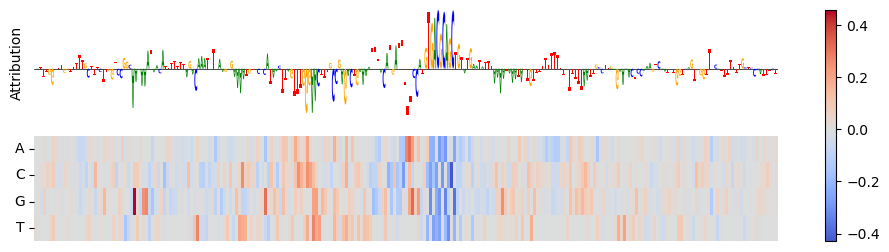

In [44]:
plot_attribution_logo_heatmap(
    attrs=ism_attrs[1],
    inputs=batch[1],
    flip_sign=True,
    figsize=(12, 3)
)

A [recent publication](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-02956-3) from Peter Koo's lab highlighted that a simple correction of the gradient by the mean value across nucleotides can improve the performance of attribution methods. We have implemented this correction in SeqExplainer and demonstrate how to use it below.

In [49]:
from seqexplainer.attributions._attributions import gradient_correction

In [53]:
# Apply the correction to the attributions
ixg_attrs_gc = gradient_correction(ixg_attrs)*batch
shap_attrs_gc = gradient_correction(shap_attrs)*batch

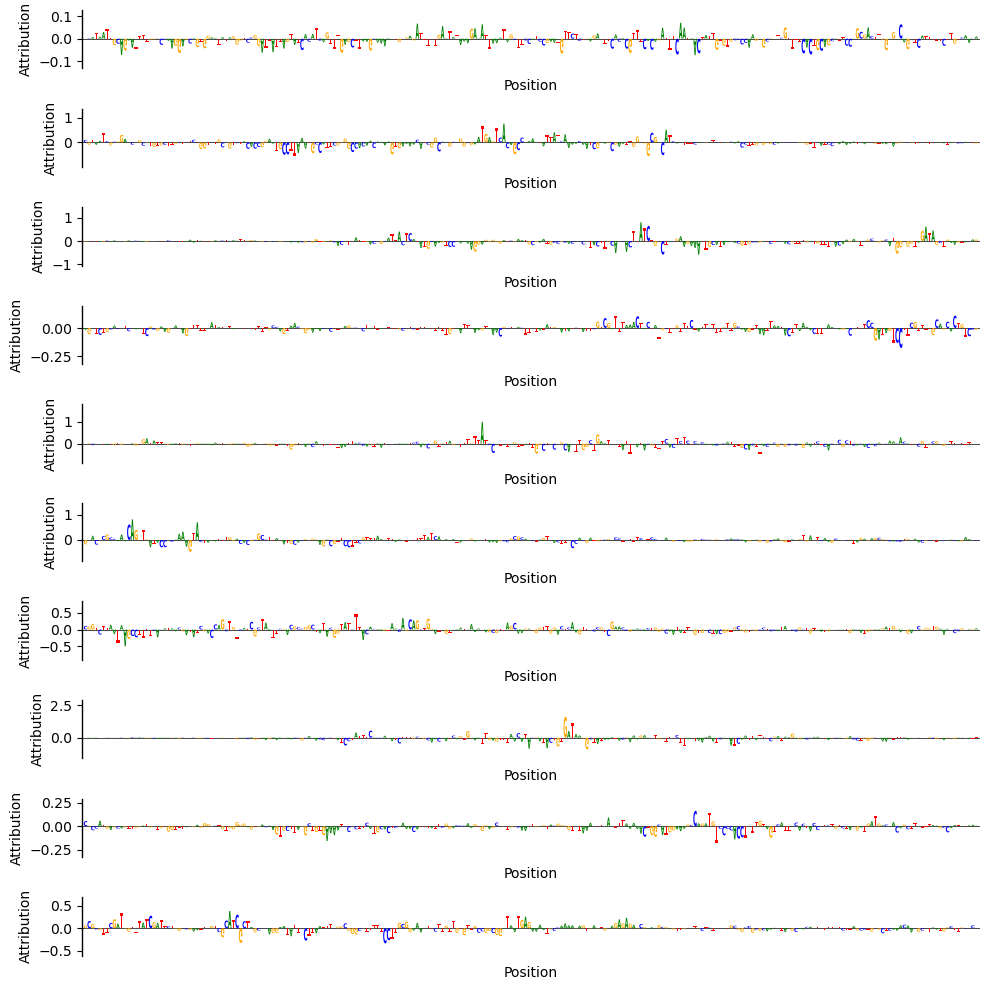

In [54]:
# Replot
plot_attribution_logos(
    attrs=ixg_attrs_gc[rand_inds],
    vocab="DNA",
)

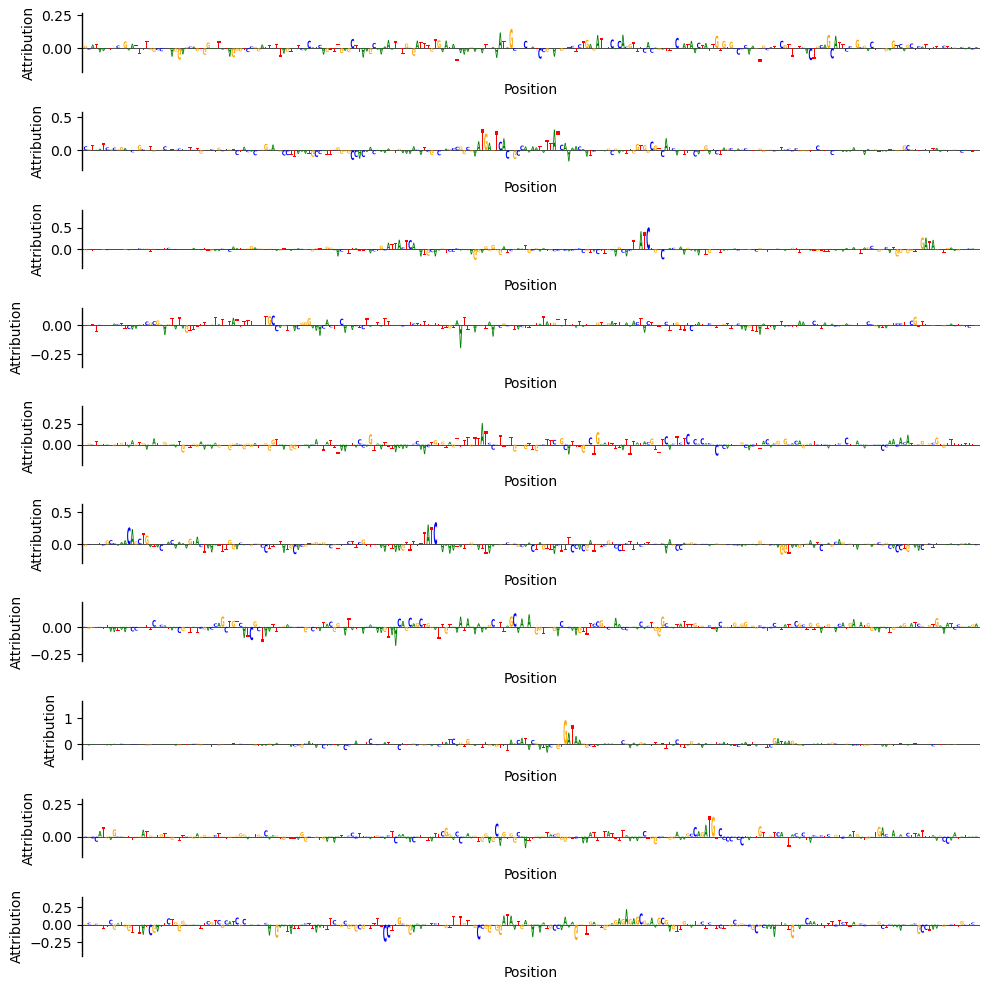

In [55]:
# Replot, don't need inputs argument since we already applied it after the correction
plot_attribution_logos(
    attrs=shap_attrs_gc[rand_inds],
    vocab="DNA",
)

## From local to global: TF-MoDISco
As we can see from most of the sequence logos, attributions can be really noisy. Without getting too much into the weeds here, this is due to the fact that neural networks are highly non-linear function approximators that may cause gradients to be very steep in some regions of the input space in ways that don't reflect the true importance of the features. Methods are being developed to overcome this problem with various strategies, but one simple idea is to aggregate attributions across many sequences to get a more global view of the model's behavior.

TF-MoDISco is a method that was developed for this purpose in genomics. Briefly, it is a clustering method that takes in attribution scores for a set of sequences and clusters them into "seqlets" that are enriched for high attribution scores. We will use the MoDISco-lite implementation Jacob Schreiber for which we have written some useful wrapper functions in SeqExplainer.

In [80]:
# EUGENe has a wrapper for this function called `modisco` that can also be used here
from modiscolite.tfmodisco import TFMoDISco

In [82]:
# All sequences
shap_attrs = attribute(
    model,
    inputs=x_test,
    method="GradientShap",
    target=0,
    batch_size=128,
    references="dinuc_shuffle",
    stdevs=0.1,
    n_samples=100
)

Computing attributions on batches of size 128:   0%|          | 0/322 [00:00<?, ?it/s]

In [91]:
pos_patterns, neg_patterns = TFMoDISco(
    hypothetical_contribs=shap_attrs.transpose(0, 2, 1),
    one_hot=x_test.transpose(0, 2, 1),
)

We now have our positive and negative clusters of seqlets that we can use to do things like generate position frequency matrices, sequence logos and more. To run the other functions for these using `modisco-lite`, we need to save these seqlets in a `hdf5` file.

In [94]:
from modiscolite.io import save_hdf5

In [95]:
output_dir = "/cellar/users/aklie/projects/ML4GLand/tutorials/EUGENe/tutorial_output/"
save_hdf5(os.path.join(output_dir, "modisco.h5"), pos_patterns, neg_patterns)

These seqlets can then be treated a lot like the maximimally activaing seqlets from the filter interpretation tutorial. For the purposes of this tutorial, we will just plot the sequence logos for the positive and negative clusters. 

In [96]:
from seqexplainer.attributions._modisco import modisco_logos

In [98]:
modisco_logos(
    modisco_h5_file=os.path.join(output_dir, "modisco.h5"),
    output_dir=os.path.join(output_dir, "modisco_logos"),
)

['pos_patterns.pattern_0',
 'pos_patterns.pattern_1',
 'pos_patterns.pattern_2',
 'pos_patterns.pattern_3',
 'pos_patterns.pattern_4',
 'pos_patterns.pattern_5',
 'pos_patterns.pattern_6',
 'pos_patterns.pattern_7',
 'pos_patterns.pattern_8',
 'pos_patterns.pattern_9',
 'pos_patterns.pattern_10',
 'pos_patterns.pattern_11',
 'neg_patterns.pattern_0',
 'neg_patterns.pattern_1',
 'neg_patterns.pattern_2',
 'neg_patterns.pattern_3',
 'neg_patterns.pattern_4',
 'neg_patterns.pattern_5',
 'neg_patterns.pattern_6',
 'neg_patterns.pattern_7',
 'neg_patterns.pattern_8',
 'neg_patterns.pattern_9',
 'neg_patterns.pattern_10',
 'neg_patterns.pattern_11',
 'neg_patterns.pattern_12',
 'neg_patterns.pattern_13',
 'neg_patterns.pattern_14',
 'neg_patterns.pattern_15',
 'neg_patterns.pattern_16',
 'neg_patterns.pattern_17',
 'neg_patterns.pattern_18',
 'neg_patterns.pattern_19',
 'neg_patterns.pattern_20',
 'neg_patterns.pattern_21',
 'neg_patterns.pattern_22',
 'neg_patterns.pattern_23',
 'neg_patter

## Avoiding overinterpretation
Like with filter interpretation. This approach is valuable for intepreting what features a model is learning to use to make predictions. Attribution analysis has the added benefit of being able to do this for individual sequences. However, there are some important caveats to keep in mind when interpreting the results of an attribution analysis.

1. First and foremost, attributions from single sequences can be very noisy. This has been discussed in several publications (e.g. https://www.sciencedirect.com/science/article/pii/S2452310020300032?via%3Dihub) and can lead to confusing or misleading interpretations. We recommend using a global approach like TF-MoDISco to aggregate attributions across many sequences.
2. Most attribution methods only consider the contribution of a single nucleotide at a time. This means that they cannot capture interactions between nucleotides.
3. Related to above, attribtions do not quantify the importance of whole motifs, which we know are important for many of our predictive tasks. This is where a global importance analysis can be useful.

Put succintely, DNNs (especially CNNs) learn really complex functions that can do funky things in the input space. This can lead to noisy gradients for single sequences that can make interpetation challenging.

# DONE!

---

# Scratch